# Import Modules

In [113]:
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt 
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Data Preprocessing

In [34]:
# Import data from files
os.chdir('/Users/talhajamal/Desktop/Code/BigData1Project')
data = pd.read_csv("data/Returns_Data.csv")
data['date'] = pd.to_datetime(data['date'], dayfirst=False)
characteristics = pd.read_csv("data/Stock_Characteristics_Data.csv")
dictionary = pd.read_excel("data/StockDataDictionary.xlsx")

# Create new dataframes
prices = data.pivot(index='date', columns='ticker', values='PRC')
volume = data.pivot(index='date', columns='ticker', values='VOL')
returns = data.pivot(index='date', columns='ticker', values='RET')
#returns = returns * 100 # Scale returns to percentage
# Summary of Returns
returns_summary = returns.describe()
shares_outstanding = data.pivot(index='date', columns='ticker', values='SHROUT')
value_weighted_returns = data.pivot(index='date', columns='ticker', values='vwretd')
equal_weighted_returns = data.pivot(index='date', columns='ticker', values='ewretd')
tickers = prices.columns # List of Tickers

# Spit Test and Train data
slice_date = dt(year=2018, month=1, day=1)
y_train = returns.loc[:slice_date]
y_test = returns.loc[slice_date:]

# Feature Generation

## Feature 1: On Balance Volume

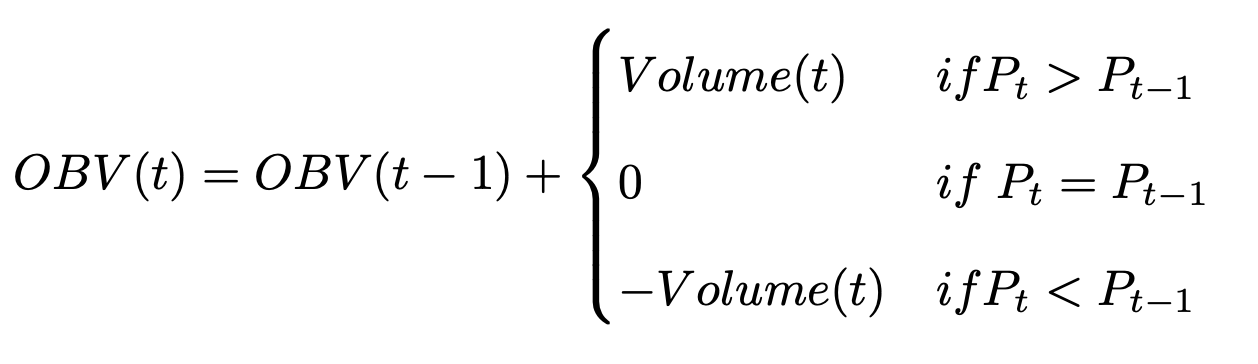

In [35]:
# Feature 1: On Balance Volume
def calculate_obv(stock_returns, stock_volumes):
    """ Function to calculate On Balance Volume"""
    sign = stock_returns.apply(np.sign) # Sign Series: 1 if the return is positive, -1 if negative, 0 if unchanged
    daily_obv_changes = sign * stock_volumes # Daily OBV changes
    obv = daily_obv_changes.cumsum() # Cumulative sum of daily changes
    return obv

# Apply the function to each stock (column)
OBV = returns.apply(lambda col: calculate_obv(col, volume[col.name]), axis=0)

## Feature 2: Stochastic Oscillator %K

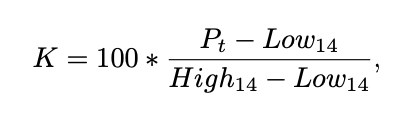

In [36]:
def stochastic_oscillator_k(prices, window):
    low = prices.rolling(window).min()
    high = prices.rolling(window).max()
    K = 100 * ( ( prices - low ) / ( high - low ) )
    return K

stochastic_oscillator = stochastic_oscillator_k(prices, 14)
#stochastic_oscillator.dropna(inplace=True)

## Feature 3: MACD

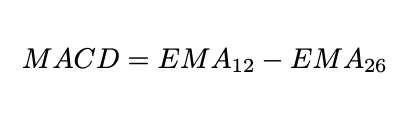

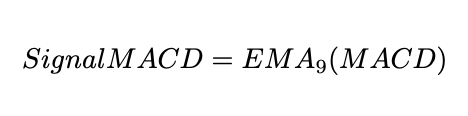

In [37]:
def get_macd(prices, short_period, long_period):
    ema_short = prices.ewm(span=short_period, adjust=False).mean()
    ema_long = prices.ewm(span=long_period, adjust=False).mean()
    return ema_short - ema_long

def get_signal_macd(macd, signal_period):
    signal = macd.ewm(span = signal_period, adjust=False).mean()
    return signal

macd = get_macd(prices, 12, 26)
signal_macd = get_signal_macd(macd, 9)

## Feature 4: 

# XGBoost

In [116]:
def run_xgboost_predictions(ticker):
    """ Function to run an xgboost algorithm and make predictions on one stock """
    # Create dataframe with the respective features and output
    xgboost_data = pd.DataFrame(
        {
            'Feature1' : OBV[ticker],
            'Feature2' : stochastic_oscillator[ticker],
            'Feature3' : macd[ticker],
            'Returns Direction' : [1 if x > 0 else 0 for x in returns[ticker]]
        }
    )
    xgboost_data.dropna(inplace=True)

    # Convert Features into Array X and Output in Array y
    X = xgboost_data.iloc[:,:-1].values
    y = xgboost_data.iloc[:,-1].values
    
    # Split Data into Training and Testing Splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    
    model = XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #print(f"Accuracy of the XGBoost Model for {ticker}: {accuracy}")

    result = {
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1_score': f1
    }

    return result

In [119]:
cross_sectional_results = pd.DataFrame(index=tickers, columns=['accuracy', 'precision', 'recall', 'f1_score'])

for ticker in tickers:
    result = run_xgboost_predictions(ticker)
    output = [result['accuracy'], result['precision'], result['recall'], result['f1_score']]
    cross_sectional_results.loc[ticker] = output

In [120]:
cross_sectional_results

,accuracy,precision,recall,f1_score
ticker,,,,
ADI,65.217391,0.677193,0.658703,0.66782
ADP,71.92029,0.774744,0.718354,0.745484
ADSK,68.297101,0.700326,0.721477,0.710744
AFL,70.289855,0.726384,0.735974,0.731148
AIZ,68.115942,0.693333,0.712329,0.702703
...,...,...,...,...
VZ,72.101449,0.760714,0.71,0.734483
WAT,71.195652,0.733333,0.735786,0.734558
WY,72.644928,0.745981,0.763158,0.754472


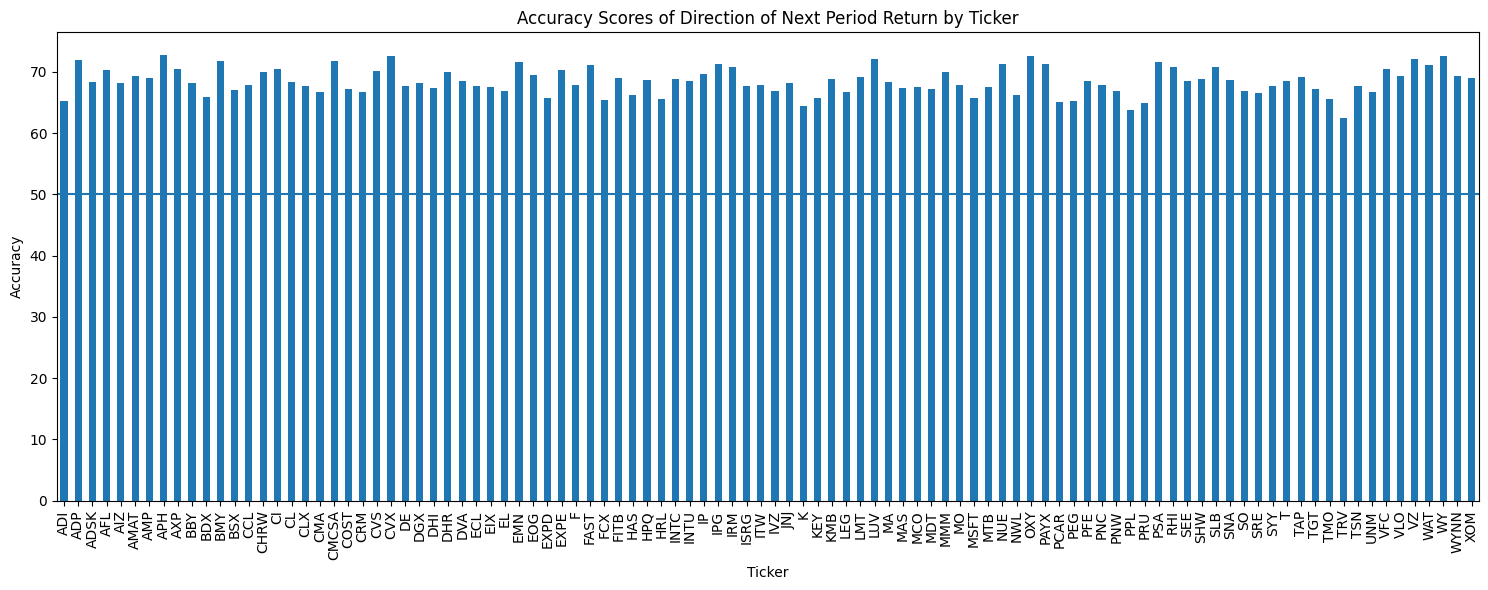

In [121]:
# Assuming 'df' is your DataFrame
cross_sectional_results['accuracy'].plot(kind='bar', figsize=(15, 6))
plt.title('Accuracy Scores of Direction of Next Period Return by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Accuracy')
plt.axhline(50)
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

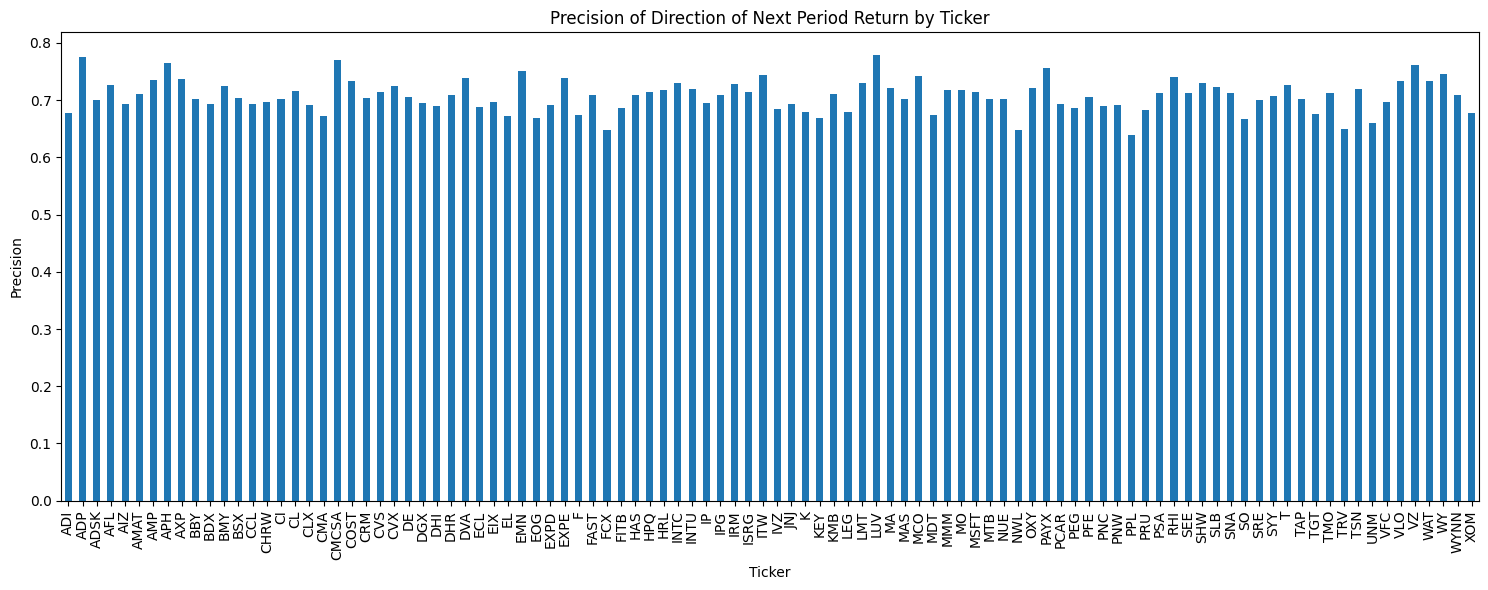

In [125]:
# Assuming 'df' is your DataFrame
cross_sectional_results['precision'].plot(kind='bar', figsize=(15, 6))
plt.title('Precision of Direction of Next Period Return by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Precision')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

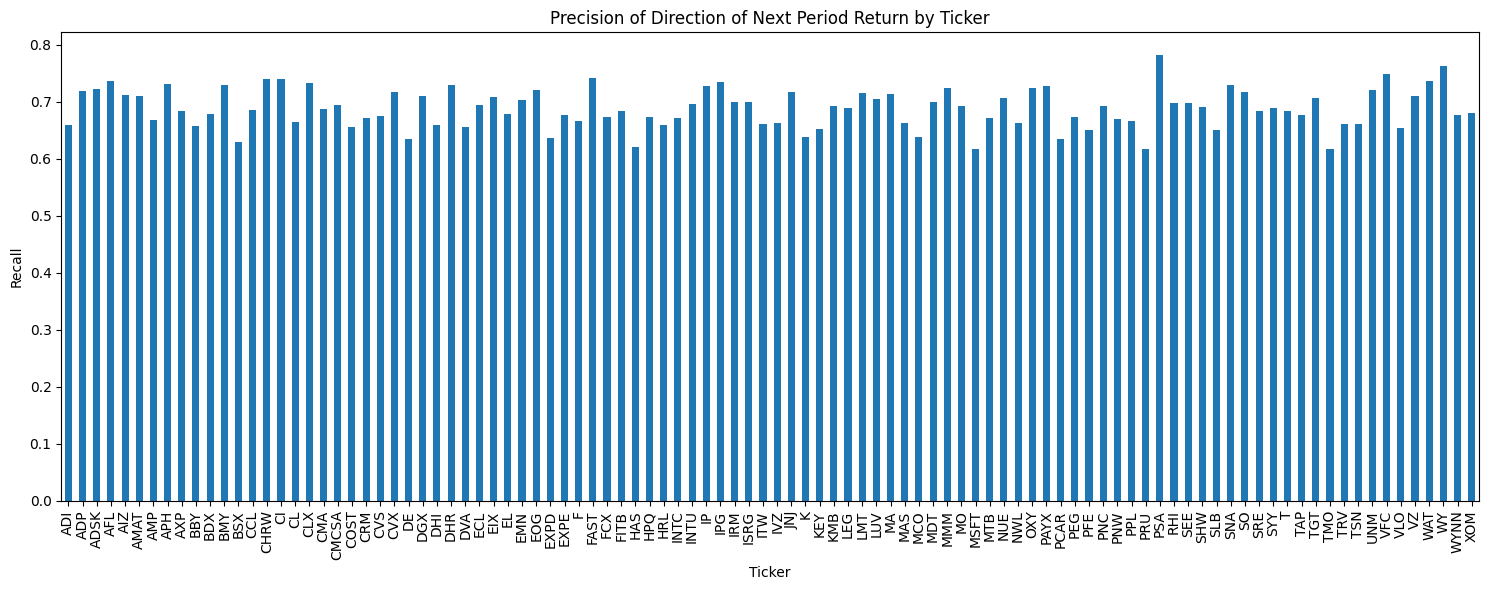

In [126]:
# Assuming 'df' is your DataFrame
cross_sectional_results['recall'].plot(kind='bar', figsize=(15, 6))
plt.title('Precision of Direction of Next Period Return by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Recall')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

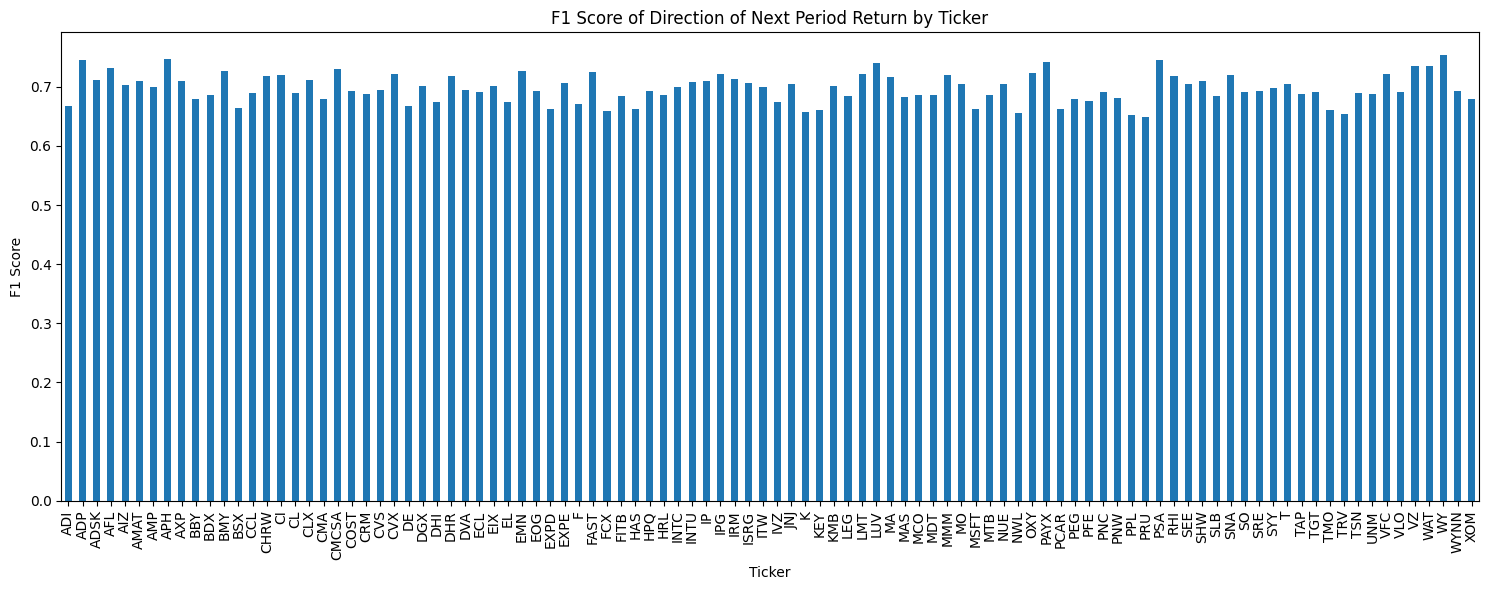

In [127]:
# Assuming 'df' is your DataFrame
cross_sectional_results['f1_score'].plot(kind='bar', figsize=(15, 6))
plt.title('F1 Score of Direction of Next Period Return by Ticker')
plt.xlabel('Ticker')
plt.ylabel('F1 Score')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()